**Model Development**

**Multi - Layer Perceptron (MLP)**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# === Load dataset ===
df = pd.read_csv("/content/xyz.csv")  # Ensure 'xyz.csv' has features + label column

# === Split features and labels ===
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# === Encode class labels ===
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# === Split into training and testing sets (80-20) ===
X_train, X_test, y_train_cat, y_test_cat = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

# === Standardize features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Build model ===
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Train model ===
history = model.fit(
    X_train_scaled, y_train_cat,
    epochs=30, batch_size=32,
    validation_split=0.1,
    verbose=1
)

# === Evaluate and report on training data ===
print("\nEvaluating on training data:")
y_train_pred = model.predict(X_train_scaled)
y_train_pred_labels = np.argmax(y_train_pred, axis=1)
y_train_true_labels = np.argmax(y_train_cat, axis=1)
print(classification_report(y_train_true_labels, y_train_pred_labels, target_names=le.classes_))

# === Evaluate and report on testing data ===
print("\nEvaluating on testing data:")
y_test_pred = model.predict(X_test_scaled)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test_cat, axis=1)
print(classification_report(y_test_true_labels, y_test_pred_labels, target_names=le.classes_))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.2266 - loss: 2.3137 - val_accuracy: 0.2162 - val_loss: 1.8254
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4428 - loss: 1.3956 - val_accuracy: 0.2432 - val_loss: 1.8376
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6130 - loss: 1.0652 - val_accuracy: 0.2432 - val_loss: 1.8269
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6846 - loss: 0.8193 - val_accuracy: 0.2973 - val_loss: 1.9421
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8028 - loss: 0.6112 - val_accuracy: 0.2973 - val_loss: 2.0541
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8235 - loss: 0.4862 - val_accuracy: 0.2703 - val_loss: 2.0471
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8790 - loss: 0.3867 - val_accuracy: 0.2973 - val_loss: 2.1768
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8895 - loss: 0.3480 - val_accuracy: 0.2703 - v

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Multi - Layer Perceptron (MLP) after preventing Overfitting**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# === Load dataset ===
df = pd.read_csv('xyz.csv')  # Ensure 'xyz.csv' has features + label column

# === Split features and labels ===
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# === Encode class labels ===
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# === Standardize features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Compute class weights for imbalanced data ===
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# === Define model function ===
def create_model(input_dim, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# === Cross-validation ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
val_reports = []

for train_index, val_index in kf.split(X_scaled, y_encoded):
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y_cat[train_index], y_cat[val_index]

    # === Early Stopping ===
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # === Create and train model ===
    model = create_model(X_train.shape[1], y_train.shape[1])
    history = model.fit(
        X_train, y_train,
        epochs=30, batch_size=32,
        validation_data=(X_val, y_val),
        class_weight=class_weight_dict,
        callbacks=[early_stopping],
        verbose=1
    )

    # === Evaluate model on validation set ===
    val_pred = model.predict(X_val)
    val_pred_labels = np.argmax(val_pred, axis=1)
    val_true_labels = np.argmax(y_val, axis=1)
    val_report = classification_report(val_true_labels, val_pred_labels, target_names=le.classes_)
    val_reports.append(val_report)

# === Print average classification report from cross-validation ===
print("\nAverage Classification Report (from Cross-Validation):")
print(val_reports)

# === Evaluate final model on full training and test sets ===
print("\nEvaluating final model on full training data:")
model = create_model(X_scaled.shape[1], y_cat.shape[1])
model.fit(X_scaled, y_cat, epochs=30, batch_size=32, validation_split=0.1, class_weight=class_weight_dict)

# === Evaluate and report on training data ===
y_train_pred = model.predict(X_scaled)
y_train_pred_labels = np.argmax(y_train_pred, axis=1)
y_train_true_labels = np.argmax(y_cat, axis=1)
print(classification_report(y_train_true_labels, y_train_pred_labels, target_names=le.classes_))

# === Evaluate and report on testing data ===
print("\nEvaluating final model on testing data:")
y_test_pred = model.predict(X_test_scaled)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test_cat, axis=1)
print(classification_report(y_test_true_labels, y_test_pred_labels, target_names=le.classes_))

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2563 - loss: 2.2343 - val_accuracy: 0.2391 - val_loss: 1.8655
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5227 - loss: 1.2622 - val_accuracy: 0.2717 - val_loss: 1.9404
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6336 - loss: 0.9236 - val_accuracy: 0.3587 - val_loss: 1.8684
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6960 - loss: 0.7956 - val_accuracy: 0.3696 - val_loss: 1.8779
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8015 - loss: 0.5882 - val_accuracy: 0.3478 - val_loss: 1.8959
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8383 - loss: 0.4568 - val_accuracy: 0.3587 - val_loss: 1.9038
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.1819 - loss: 2.3830 - val_accuracy: 0.2418 - val_loss: 1.6920
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4580 - loss: 1.4196 - val_accuracy: 0.2527 - val_loss: 1.7038
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6383 - loss: 0.9189 - val_accuracy: 0.2747 - val_loss: 1.7573
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7011 - loss: 0.7262 - val_accuracy: 0.2747 - val_loss: 1.8066
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7826 - loss: 0.6311 - val_accuracy: 0.3187 - val_loss: 1.8259
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8992 - loss: 0.3883 - val_accuracy: 0.2418 - val_loss: 1.9042


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.2679 - loss: 2.0101 - val_accuracy: 0.3187 - val_loss: 1.6745
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4877 - loss: 1.3088 - val_accuracy: 0.3516 - val_loss: 1.7030
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5685 - loss: 1.1116 - val_accuracy: 0.3077 - val_loss: 1.6943
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7073 - loss: 0.7637 - val_accuracy: 0.3407 - val_loss: 1.6847
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7699 - loss: 0.6337 - val_accuracy: 0.3846 - val_loss: 1.7418
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8561 - loss: 0.4551 - val_accuracy: 0.3187 - val_loss: 1.7802
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.2100 - loss: 2.2114 - val_accuracy: 0.2637 - val_loss: 1.6342
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4032 - loss: 1.4190 - val_accuracy: 0.2308 - val_loss: 1.6047
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6336 - loss: 0.9985 - val_accuracy: 0.3187 - val_loss: 1.5377
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7050 - loss: 0.7872 - val_accuracy: 0.3516 - val_loss: 1.5479
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7981 - loss: 0.5436 - val_accuracy: 0.3626 - val_loss: 1.5782
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8433 - loss: 0.4538 - val_accuracy: 0.3407 - val_loss: 1.6217
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8856 - loss: 0.3522 - val_accuracy: 0.3736 - val_loss: 1.6641
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8955 - loss: 0.3237 - val_accuracy: 0.3956 - val_loss: 1.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.1950 - loss: 2.0176 - val_accuracy: 0.2747 - val_loss: 1.7023
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5220 - loss: 1.1976 - val_accuracy: 0.2967 - val_loss: 1.6823
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6701 - loss: 0.9080 - val_accuracy: 0.3077 - val_loss: 1.7760
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7662 - loss: 0.6983 - val_accuracy: 0.2967 - val_loss: 1.8948
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7906 - loss: 0.5653 - val_accuracy: 0.2747 - val_loss: 1.9661
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8711 - loss: 0.4244 - val_accuracy: 0.2637 - val_loss: 2.0082
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8666 - loss: 0.3844 - val_accuracy: 0.2527 - val_loss: 2.0470
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Average Classification Report (from Cross-Validation):
['              precision   

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.2163 - loss: 2.2219 - val_accuracy: 0.1522 - val_loss: 2.5710
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5144 - loss: 1.2682 - val_accuracy: 0.1957 - val_loss: 2.2900
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6503 - loss: 0.9127 - val_accuracy: 0.1957 - val_loss: 2.4678
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6914 - loss: 0.7627 - val_accuracy: 0.1957 - val_loss: 2.6287
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8311 - loss: 0.4995 - val_accuracy: 0.1304 - val_loss: 2.8953
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8101 - loss: 0.5182 - val_accuracy: 0.1739 - val_loss: 2.8592
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8755 - loss: 0.3516 - val_accuracy: 0.1957 - val_loss: 2.9168
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9282 - loss: 0.2889 - val_accuracy: 0.1087 - val_loss: 3.

**Modified Multi - Layer Perceptron (MLP)**

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.2060 - loss: 2.9477 - val_accuracy: 0.2391 - val_loss: 2.2681
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3799 - loss: 2.2891 - val_accuracy: 0.2717 - val_loss: 2.3083
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4521 - loss: 2.0326 - val_accuracy: 0.2500 - val_loss: 2.3705
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4646 - loss: 2.0073 - val_accuracy: 0.2609 - val_loss: 2.3881
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5634 - loss: 1.7033 - val_accuracy: 0.2826 - val_loss: 2.4294
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6577 - loss: 1.5390 - val_accuracy: 0.2826 - val_loss: 2.4650
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.2139 - loss: 2.8443 - val_accuracy: 0.2637 - val_loss: 2.2856
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3849 - loss: 2.2068 - val_accuracy: 0.2967 - val_loss: 2.2888
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4102 - loss: 2.0254 - val_accuracy: 0.3077 - val_loss: 2.3414
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5037 - loss: 1.8696 - val_accuracy: 0.3077 - val_loss: 2.3216
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5799 - loss: 1.6930 - val_accuracy: 0.2967 - val_loss: 2.2905
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5617 - loss: 1.6851 - val_accuracy: 0.3077 - val_loss: 2.3277
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.1918 - loss: 3.4814 - val_accuracy: 0.2308 - val_loss: 2.5177
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3288 - loss: 2.5521 - val_accuracy: 0.2857 - val_loss: 2.3259
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3941 - loss: 2.1388 - val_accuracy: 0.3297 - val_loss: 2.2480
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4848 - loss: 1.8796 - val_accuracy: 0.3736 - val_loss: 2.2705
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5752 - loss: 1.7775 - val_accuracy: 0.4066 - val_loss: 2.2463
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6316 - loss: 1.6506 - val_accuracy: 0.4066 - val_loss: 2.1947
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6446 - loss: 1.5858 - val_accuracy: 0.3846 - val_loss: 2.1714
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6380 - loss: 1.4601 - val_accuracy: 0.3626 - val_loss: 2.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.2368 - loss: 2.9832 - val_accuracy: 0.3077 - val_loss: 2.3345
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3130 - loss: 2.3645 - val_accuracy: 0.3407 - val_loss: 2.2257
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4476 - loss: 2.0717 - val_accuracy: 0.3846 - val_loss: 2.1787
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4905 - loss: 1.9240 - val_accuracy: 0.3736 - val_loss: 2.1701
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5375 - loss: 1.7937 - val_accuracy: 0.3516 - val_loss: 2.1983
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6061 - loss: 1.6542 - val_accuracy: 0.3297 - val_loss: 2.2305
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7113 - loss: 1.4563 - val_accuracy: 0.3407 - val_loss: 2.2582
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7196 - loss: 1.4039 - val_accuracy: 0.3187 - val_loss: 2.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.2307 - loss: 2.7763 - val_accuracy: 0.2747 - val_loss: 2.4539
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3822 - loss: 2.2963 - val_accuracy: 0.2747 - val_loss: 2.4008
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4285 - loss: 1.9935 - val_accuracy: 0.2747 - val_loss: 2.4104
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5367 - loss: 1.7800 - val_accuracy: 0.2527 - val_loss: 2.4218
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5851 - loss: 1.7035 - val_accuracy: 0.2747 - val_loss: 2.3534
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6753 - loss: 1.5602 - val_accuracy: 0.3187 - val_loss: 2.3297
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6605 - loss: 1.5287 - val_accuracy: 0.3187 - val_loss: 2.3283
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7256 - loss: 1.3662 - val_accuracy: 0.3297 - val_loss: 2.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.1894 - loss: 2.9420 - val_accuracy: 0.2826 - val_loss: 2.0879
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2848 - loss: 2.3755 - val_accuracy: 0.2826 - val_loss: 2.2999
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4763 - loss: 2.0142 - val_accuracy: 0.2174 - val_loss: 2.4751
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5676 - loss: 1.7483 - val_accuracy: 0.2174 - val_loss: 2.7022
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6218 - loss: 1.6543 - val_accuracy: 0.1304 - val_loss: 2.7597
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6186 - loss: 1.5318 - val_accuracy: 0.0217 - val_loss: 2.9165
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7110 - loss: 1.4380 - val_accuracy: 0.0217 - val_loss: 3.0483
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7061 - loss: 1.4030 - val_accuracy: 0.0217 - val_loss: 3.

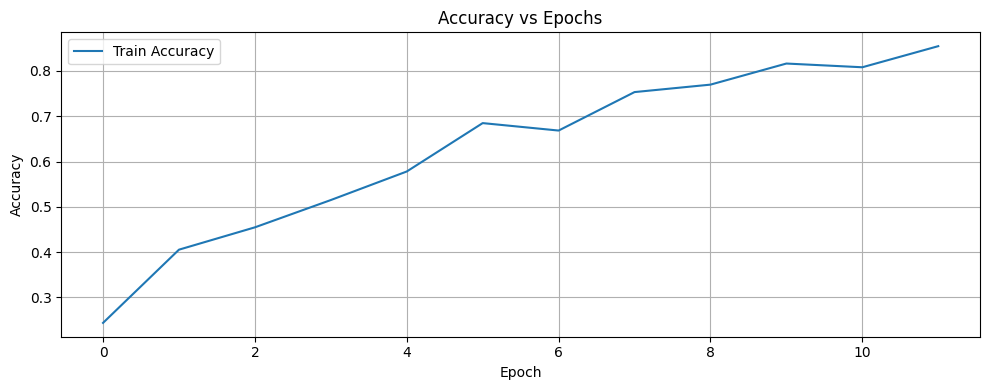

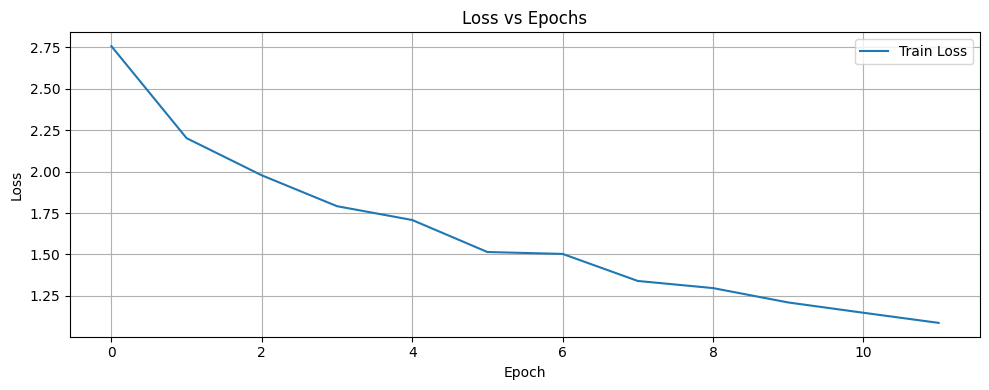

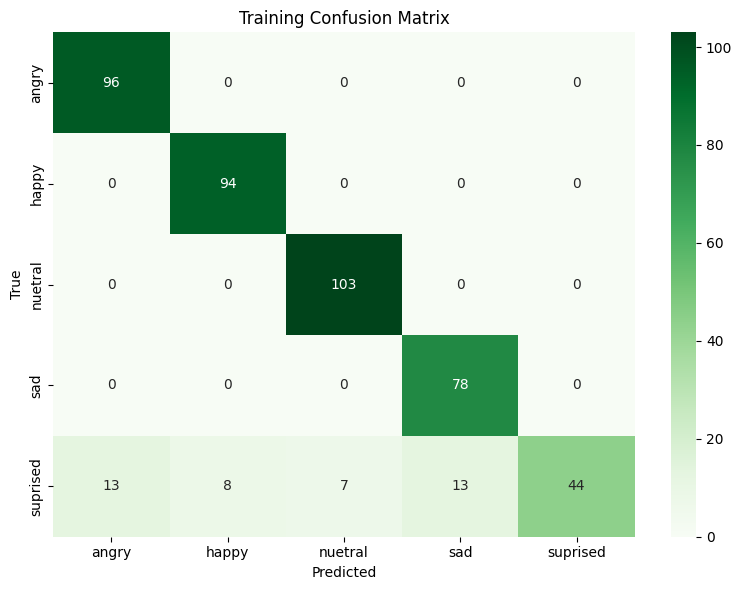

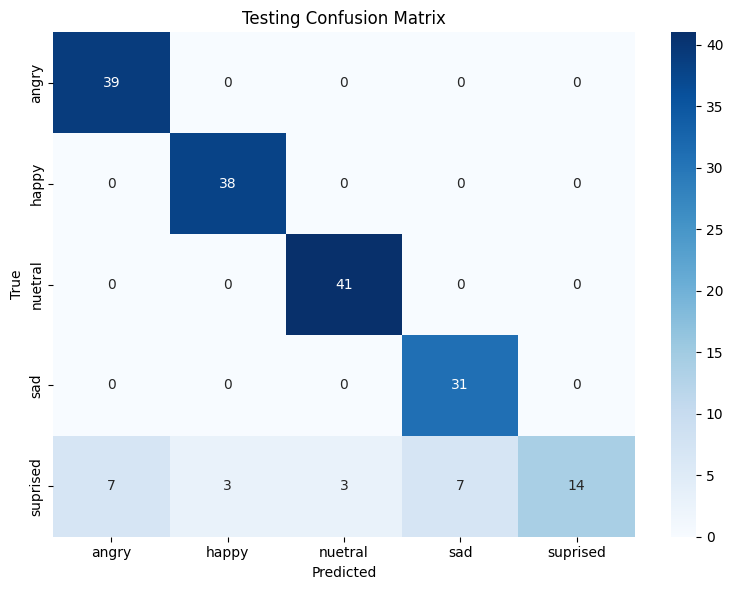

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# === Split into training and testing sets ===
X_train, X_test, y_train_cat, y_test_cat = train_test_split(
    X, y_cat, test_size=0.4, random_state=42, stratify=y_cat
)

# === Standardize features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def create_model(input_dim, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# === Cross-validation ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
val_reports = []

for train_index, val_index in kf.split(X_scaled, y_encoded):
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y_cat[train_index], y_cat[val_index]

    # === Early Stopping ===
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # === Create and train model ===
    model = create_model(X_train.shape[1], y_train.shape[1])
    history = model.fit(
        X_train, y_train,
        epochs=30, batch_size=32,
        validation_data=(X_val, y_val),
        class_weight=class_weight_dict,
        callbacks=[early_stopping],
        verbose=1
    )

    # === Evaluate model on validation set ===
    val_pred = model.predict(X_val)
    val_pred_labels = np.argmax(val_pred, axis=1)
    val_true_labels = np.argmax(y_val, axis=1)
    val_report = classification_report(val_true_labels, val_pred_labels, target_names=le.classes_)
    val_reports.append(val_report)

# === Print average classification report from cross-validation ===
print("\nAverage Classification Report (from Cross-Validation):")
print(val_reports)

# === Evaluate final model on full training and test sets ===
print("\nEvaluating final model on full training data:")
model = create_model(X_scaled.shape[1], y_cat.shape[1])
model.fit(X_scaled, y_cat, epochs=30, batch_size=32, validation_split=0.1, class_weight=class_weight_dict)

# === Evaluate and report on training data ===
y_train_pred = model.predict(X_scaled)
y_train_pred_labels = np.argmax(y_train_pred, axis=1)
y_train_true_labels = np.argmax(y_cat, axis=1)
print(classification_report(y_train_true_labels, y_train_pred_labels, target_names=le.classes_))

# === Evaluate and report on testing data ===
print("\nEvaluating final model on testing data:")
y_test_pred = model.predict(X_test_scaled)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test_cat, axis=1)
print(classification_report(y_test_true_labels, y_test_pred_labels, target_names=le.classes_))


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# === Accuracy vs Epochs ===
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Loss vs Epochs ===
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Confusion Matrix - Training ===
cm_train = confusion_matrix(y_train_true_labels, y_train_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# === Confusion Matrix - Testing ===
cm_test = confusion_matrix(y_test_true_labels, y_test_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Testing Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()






In [20]:
model.summary()

Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_285 (Dense)               │ (None, 256)            │       516,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_132         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_212 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_286 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_133         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_213 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_287 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_214 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_288 (Dense)               │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,676,561 (6.40 MB)

 Trainable params: 558,597 (2.13 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 1,117,196 (4.26 MB)